In [1]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

Meanshift

Silhouette Score: 0.17011842908881228
Davies-Bouldin Index: 1.4580342494868672


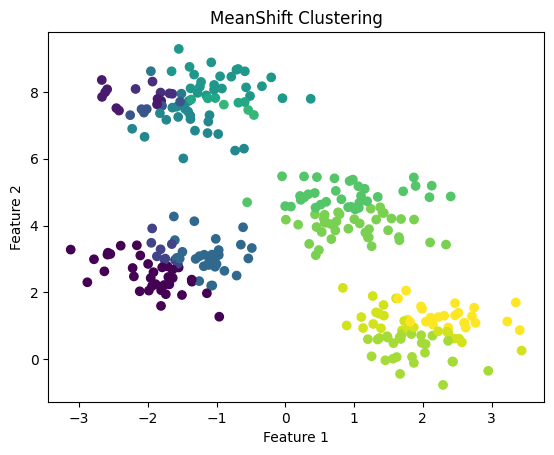

In [2]:
class MeanShift:
    def __init__(self, bandwidth=None, max_iter=300, tol=1e-3):
        self.bandwidth = bandwidth
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        if self.bandwidth is None:
            self.bandwidth = self.estimate_bandwidth(X)
        
        centroids = np.copy(X)
        for it in range(self.max_iter):
            new_centroids = np.zeros_like(centroids)
            for i, centroid in enumerate(centroids):
                in_bandwidth = X[np.linalg.norm(X - centroid, axis=1) < self.bandwidth]
                new_centroids[i] = np.mean(in_bandwidth, axis=0)
            
            shift = np.linalg.norm(new_centroids - centroids)
            centroids = new_centroids
            if shift < self.tol:
                break
        
        # labels
        unique_centroids, labels = np.unique(np.round(centroids, decimals=4), axis=0, return_inverse=True)
        self.cluster_centers_ = unique_centroids
        self.labels_ = labels

    def estimate_bandwidth(self, X):
        # simple heuristic to estimate bandwidth
        from sklearn.neighbors import NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=2).fit(X)
        distances, _ = nbrs.kneighbors(X)
        return np.mean(distances[:, 1])

# Generate sample data
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# MeanShift clustering
mean_shift = MeanShift(bandwidth=1.0)
mean_shift.fit(X)
labels = mean_shift.labels_

# performance metrics
silhouette_avg = silhouette_score(X, labels)
davies_bouldin_avg = davies_bouldin_score(X, labels)

# performance metrics
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")

# clustering result
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('MeanShift Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Meanshift ++

Silhouette Score: -0.3577907135959588
Davies-Bouldin Index: 29.939139235322365


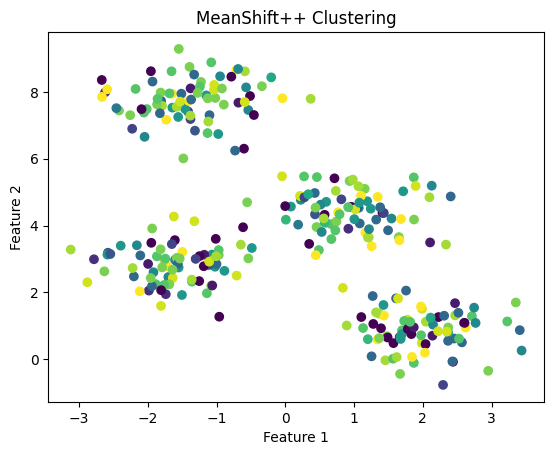

In [3]:
class MeanShiftPlusPlus:
    def __init__(self, bandwidth=None, max_iter=300, tol=1e-3, n_init=10):
        self.bandwidth = bandwidth
        self.max_iter = max_iter
        self.tol = tol
        self.n_init = n_init

    def fit(self, X):
        if self.bandwidth is None:
            self.bandwidth = self.estimate_bandwidth(X)
        
        best_centroids = None
        best_inertia = np.inf
        
        for _ in range(self.n_init):
            initial_centroids = self.initialize_centroids(X)
            centroids = self.mean_shift(X, initial_centroids)
            inertia = self.calculate_inertia(X, centroids)
            
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
        
        unique_centroids, labels = np.unique(np.round(best_centroids, decimals=4), axis=0, return_inverse=True)
        self.cluster_centers_ = unique_centroids
        self.labels_ = labels

    def mean_shift(self, X, centroids):
        for it in range(self.max_iter):
            new_centroids = np.zeros_like(centroids)
            for i, centroid in enumerate(centroids):
                in_bandwidth = X[np.linalg.norm(X - centroid, axis=1) < self.bandwidth]
                new_centroids[i] = np.mean(in_bandwidth, axis=0)
            
            shift = np.linalg.norm(new_centroids - centroids)
            centroids = new_centroids
            if shift < self.tol:
                break
        return centroids
    
    def initialize_centroids(self, X):
        n_samples, n_features = X.shape
        centroids = np.empty((0, n_features))
        
        # Random first centroid
        initial_idx = np.random.choice(n_samples)
        centroids = np.append(centroids, [X[initial_idx]], axis=0)
        
        for _ in range(1, n_samples):
            distances = np.min([np.linalg.norm(X - centroid, axis=1) for centroid in centroids], axis=0)
            probs = distances / np.sum(distances)
            next_idx = np.random.choice(n_samples, p=probs)
            centroids = np.append(centroids, [X[next_idx]], axis=0)
        
        return centroids

    def estimate_bandwidth(self, X):
        # simple heuristic to estimate bandwidth
        from sklearn.neighbors import NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=2).fit(X)
        distances, _ = nbrs.kneighbors(X)
        return np.mean(distances[:, 1])
    
    def calculate_inertia(self, X, centroids):
        inertia = 0
        for centroid in centroids:
            in_bandwidth = X[np.linalg.norm(X - centroid, axis=1) < self.bandwidth]
            inertia += np.sum((in_bandwidth - centroid) ** 2)
        return inertia

# sample data
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# MeanShift++ clustering
mean_shift_plus_plus = MeanShiftPlusPlus(bandwidth=1.0)
mean_shift_plus_plus.fit(X)
labels = mean_shift_plus_plus.labels_

# performance metrics
silhouette_avg = silhouette_score(X, labels)
davies_bouldin_avg = davies_bouldin_score(X, labels)

# \performance metrics
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")

# clustering result
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('MeanShift++ Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Quickshift

Silhouette Score: 0.2412299943798419
Davies-Bouldin Index: 0.5041335496008672


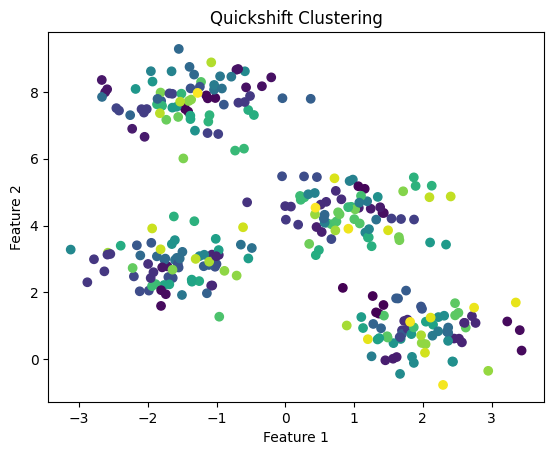

In [4]:
class Quickshift:
    def __init__(self, max_dist=1.0):
        self.max_dist = max_dist

    def fit(self, X):
        n_samples = X.shape[0]
        self.labels_ = -np.ones(n_samples)
        
        # nearest neighbors
        nn = NearestNeighbors(radius=self.max_dist).fit(X)
        distances, indices = nn.kneighbors(X, n_neighbors=2)
        
        parents = np.zeros(n_samples, dtype=int)
        for i in range(n_samples):
            if distances[i, 1] < self.max_dist:
                parents[i] = indices[i, 1]
            else:
                parents[i] = i

        # cluster ids
        cluster_id = 0
        for i in range(n_samples):
            if self.labels_[i] == -1:
                current = i
                while self.labels_[current] == -1:
                    self.labels_[current] = cluster_id
                    current = parents[current]
                cluster_id += 1

        self.cluster_centers_ = self.compute_centers(X)
    
    def compute_centers(self, X):
        unique_labels = np.unique(self.labels_)
        centers = np.array([X[self.labels_ == label].mean(axis=0) for label in unique_labels])
        return centers

# Generating sample data
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Perform Quickshift clustering
quickshift = Quickshift(max_dist=1.0)
quickshift.fit(X)
labels = quickshift.labels_

# performance metrics
silhouette_avg = silhouette_score(X, labels)
davies_bouldin_avg = davies_bouldin_score(X, labels)

# performance metrics
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")

# Plotting the clustering result
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('Quickshift Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
